# Practical 2 — Embeddings-first workflows with a Geospatial Foundation Model (Clay)

**Road to SKA: Foundation Models, Embeddings, and Latent Spaces**

In this practical you will build an **embeddings-first** workflow:

1. Load **pre-computed Clay embeddings** for a small AOI.
2. Create labels by joining training points to embedding “chips”.
3. Train a lightweight classifier (Random Forest / Logistic Regression) on embeddings.
4. Run inference over *all* embeddings to “discover” target locations.
5. Build a **similarity search** index (nearest neighbours) to do retrieval and qualitative QA.

This approach mirrors a common pattern for foundation models:
> **Freeze the foundation model → treat embeddings as features → train a small head**

---

## Key links / references

**Clay Foundation Model**
- Docs: https://clay-foundation.github.io/model/  
- “Basic use” (generating embeddings): https://clay-foundation.github.io/model/getting-started/basic_use.html  
- “Train classification on embeddings” tutorial (this practical is a simplified, dependency-light version): https://clay-foundation.github.io/model/finetune/finetune-on-embeddings.html  

**Example embedding dataset used here**
- Hugging Face dataset: `made-with-clay/classify-embeddings-sf-baseball-marinas`  
  (Embeddings in GeoParquet + training points in GeoJSON, used in Clay’s tutorial.)  
  https://huggingface.co/datasets/made-with-clay/classify-embeddings-sf-baseball-marinas

**Background**
- Embeddings as representations: https://clay-foundation.github.io/model/  
- Masked Autoencoders (context): https://arxiv.org/abs/2111.06377


## 1. About Clay and Geospatial Embeddings

### What is Clay?

**Clay** is an open-source **geospatial foundation model** trained on petabytes of satellite imagery from multiple sensors (Sentinel-2, Landsat, NAIP, etc.). Like foundation models in NLP (BERT, GPT) or vision (CLIP, DINOv2), Clay learns general-purpose representations that transfer to many downstream tasks.

Clay uses a **Masked Autoencoder (MAE)** architecture:
1. Input satellite image chips are divided into patches
2. A large fraction (~75%) of patches are randomly masked
3. The model learns to reconstruct the missing patches
4. The encoder learns rich representations in the process

The key insight: by learning to "fill in the blanks" across diverse imagery, the model captures semantic understanding of land cover, urban structure, water bodies, vegetation patterns, and more — without any labels.

### What are embeddings?

An **embedding** is a dense vector representation of an input (here, a satellite image chip). Clay's encoder maps each 256×256 pixel chip to a dense vector:

$$\text{image chip} \xrightarrow{\text{Clay encoder}} \mathbf{z} \in \mathbb{R}^{d}$$

- **Clay v1** (ViT-Base backbone): **768 dimensions** — used for the precomputed embeddings in this practical
- **Clay v1.5** (larger backbone): **1024 dimensions**

These embeddings have useful properties:
- **Semantic similarity**: chips with similar content (e.g., two marinas) have similar embeddings
- **Transferability**: embeddings trained on one task generalise to others
- **Efficiency**: classifiers on 768-d vectors are much cheaper than training on raw pixels

### The embeddings-first workflow

Instead of fine-tuning the entire foundation model (expensive, requires GPU), we:

1. **Freeze** the pretrained Clay encoder
2. **Extract embeddings** for our imagery (can be precomputed)
3. **Train a lightweight head** (Random Forest, logistic regression, small MLP) on embeddings
4. **Run inference** using the small head

This is the same pattern used with CLIP embeddings for image search, or sentence transformers for text retrieval.

## 2. Setup

This notebook aims to keep dependencies lightweight.

Required:
- `numpy`, `pandas`, `scikit-learn`
- `pyarrow` (for reading parquet)

Recommended:
- `shapely` (spatial point-in-polygon checks)

Optional:
- `faiss-cpu` (fast similarity search)

In [1]:
# Optional installs (uncomment if needed)
# %pip -q install pandas numpy scikit-learn pyarrow shapely
# %pip -q install faiss-cpu  # optional
# %pip -q install contextily  # for basemap tiles

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# Shapely for geometry ops (optional but recommended)
try:
    from shapely.geometry import shape, Point
    from shapely import from_wkb  # shapely>=2
    SHAPELY_OK = True
except Exception as e:
    SHAPELY_OK = False
    print("Shapely not available. Spatial join will not work without it. Error:", repr(e))

# Contextily for basemap tiles (optional)
try:
    import contextily as cx
    CONTEXTILY_OK = True
except ImportError:
    CONTEXTILY_OK = False
    print("contextily not available. Maps will render without basemap tiles.")
    print("Install with: pip install contextily")

# Helper: convert lon/lat (EPSG:4326) to Web Mercator (EPSG:3857)
def lonlat_to_webmerc(lon, lat):
    """Convert longitude/latitude arrays to Web Mercator coordinates."""
    lon = np.asarray(lon)
    lat = np.asarray(lat)
    x = lon * 20037508.34 / 180
    y = np.log(np.tan((90 + lat) * np.pi / 360)) / (np.pi / 180)
    y = y * 20037508.34 / 180
    return x, y

## 3. Configuration

### About the SF Bay Area embedding dataset

We use **precomputed Clay embeddings** from the Hugging Face dataset:  
[`made-with-clay/classify-embeddings-sf-baseball-marinas`](https://huggingface.co/datasets/made-with-clay/classify-embeddings-sf-baseball-marinas)

#### How the embeddings were created

1. **Source imagery**: NAIP (National Agriculture Imagery Program) aerial imagery from 2022, covering the San Francisco Bay Area at 60 cm/pixel resolution.

2. **Chipping**: The imagery was divided into non-overlapping **256×256 pixel chips** (~150m × 150m on the ground). Each chip has a geographic footprint stored as a polygon geometry.

3. **Embedding extraction**: Each chip was passed through the **Clay v1 encoder** (ViT-Base), producing a **768-dimensional embedding vector**.

4. **Storage format**: Embeddings are saved as **GeoParquet** files (`.gpq`), with columns:
   - `embeddings`: the 768-d vector (as a list/array)
   - `geometry`: the chip's geographic footprint (WKB-encoded polygon)
   - `item_id`: identifier linking back to the source NAIP tile

#### File naming convention

The filenames follow NAIP tile naming:
```
embeddings_ca_m_3712213_ne_10_060_20220518.gpq
          │   │ │       │  │  │   └── date (YYYYMMDD)
          │   │ │       │  │  └── resolution (60cm)
          │   │ │       │  └── UTM zone
          │   │ │       └── quadrant (ne/nw/se/sw)
          │   │ └── USGS tile ID
          │   └── "m" for "mosaic"
          └── state (California)
```

#### Spatial coverage

Each GeoParquet file covers one NAIP tile quadrant (~3.75 × 3.75 km). Together, the 20 files span portions of San Francisco, Oakland, and the East Bay — areas containing the target features (baseball fields and marinas).

#### Training labels

The dataset includes hand-labelled **GeoJSON point files**:
- `marinas.geojson`: points marking marina locations (class=1) and negative examples (class=0)
- `baseball.geojson`: points marking baseball diamonds (class=1) and negatives (class=0)

We spatially join these points to embedding chips to create training labels.

In [2]:
DATA_DIR = Path("./data/practical2_clay")
DATA_DIR.mkdir(parents=True, exist_ok=True)

HF_BASE = "https://huggingface.co/datasets/made-with-clay/classify-embeddings-sf-baseball-marinas/resolve/main"

# All available embedding files from the Clay tutorial (GeoParquet)
# Organized by USGS tile ID for geographic splitting
EMBED_FILES_ALL = [
    # Tile row 3712212-3712214 (northern area)
    "embeddings_ca_m_3712212_ne_10_060_20220519.gpq",
    "embeddings_ca_m_3712212_nw_10_060_20220519.gpq",
    "embeddings_ca_m_3712212_se_10_060_20220519.gpq",
    "embeddings_ca_m_3712213_ne_10_060_20220518.gpq",
    "embeddings_ca_m_3712213_nw_10_060_20220518.gpq",
    "embeddings_ca_m_3712213_se_10_060_20220518.gpq",
    "embeddings_ca_m_3712213_sw_10_060_20220518.gpq",
    "embeddings_ca_m_3712214_sw_10_060_20220518.gpq",
    "embeddings_ca_m_3712214_nw_10_060_20220518.gpq",
    # Tile row 3712220-3712222 (central area)
    "embeddings_ca_m_3712220_ne_10_060_20220519.gpq",
    "embeddings_ca_m_3712221_ne_10_060_20220518.gpq",
    "embeddings_ca_m_3712221_nw_10_060_20220518.gpq",
    "embeddings_ca_m_3712221_sw_10_060_20220518.gpq",
    "embeddings_ca_m_3712221_se_10_060_20220518.gpq",
    "embeddings_ca_m_3712222_sw_10_060_20220518.gpq",
    "embeddings_ca_m_3712222_nw_10_060_20220518.gpq",
    # Tile row 3712228-3712230 (southern area - HELD OUT FOR SPATIAL TEST)
    "embeddings_ca_m_3712228_ne_10_060_20220519.gpq",
    "embeddings_ca_m_3712229_ne_10_060_20220518.gpq",
    "embeddings_ca_m_3712229_nw_10_060_20220518.gpq",
    "embeddings_ca_m_3712230_nw_10_060_20220518.gpq",
]

# Split files geographically: train on north/central, test on southern tiles
TRAIN_FILES = [f for f in EMBED_FILES_ALL if not any(t in f for t in ['3712228', '3712229', '3712230'])]
SPATIAL_TEST_FILES = [f for f in EMBED_FILES_ALL if any(t in f for t in ['3712228', '3712229', '3712230'])]

print(f"Training files: {len(TRAIN_FILES)} tiles (north/central Bay Area)")
print(f"Spatial test files: {len(SPATIAL_TEST_FILES)} tiles (southern Bay Area - held out)")

# Training point files (GeoJSON)
POINT_FILES = ["marinas.geojson", "baseball.geojson"]

TASK = "marinas"  # "marinas" or "baseball"

RANDOM_SEED = 42

print(f"\nTask: {TASK}")

Training files: 16 tiles (north/central Bay Area)
Spatial test files: 4 tiles (southern Bay Area - held out)

Task: marinas


## 4. Download embedding files + training points

This uses direct URLs from Hugging Face (same as Clay's tutorial). If files already exist locally, we skip re-downloading.

In [3]:
import requests

def download_file(url: str, dst: Path, chunk_size: int = 1 << 20):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists() and dst.stat().st_size > 0:
        return
    with requests.get(url, stream=True, timeout=60) as r:
        r.raise_for_status()
        with open(dst, "wb") as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)

# Download all files (training + spatial test + labels)
all_embed_files = TRAIN_FILES + SPATIAL_TEST_FILES
for fn in all_embed_files + POINT_FILES:
    url = f"{HF_BASE}/{fn}"
    dst = DATA_DIR / fn
    print("Downloading:", fn)
    download_file(url, dst)

print("\nDone. Local files:")
for p in sorted(DATA_DIR.glob("*")):
    print(" -", p.name, f"({p.stat().st_size/1e6:.1f} MB)")

Downloading: embeddings_ca_m_3712212_ne_10_060_20220519.gpq
Downloading: embeddings_ca_m_3712212_nw_10_060_20220519.gpq
Downloading: embeddings_ca_m_3712212_se_10_060_20220519.gpq
Downloading: embeddings_ca_m_3712213_ne_10_060_20220518.gpq
Downloading: embeddings_ca_m_3712213_nw_10_060_20220518.gpq
Downloading: embeddings_ca_m_3712213_se_10_060_20220518.gpq
Downloading: embeddings_ca_m_3712213_sw_10_060_20220518.gpq
Downloading: embeddings_ca_m_3712214_sw_10_060_20220518.gpq
Downloading: embeddings_ca_m_3712214_nw_10_060_20220518.gpq
Downloading: embeddings_ca_m_3712220_ne_10_060_20220519.gpq
Downloading: embeddings_ca_m_3712221_ne_10_060_20220518.gpq
Downloading: embeddings_ca_m_3712221_nw_10_060_20220518.gpq
Downloading: embeddings_ca_m_3712221_sw_10_060_20220518.gpq
Downloading: embeddings_ca_m_3712221_se_10_060_20220518.gpq
Downloading: embeddings_ca_m_3712222_sw_10_060_20220518.gpq
Downloading: embeddings_ca_m_3712222_nw_10_060_20220518.gpq
Downloading: embeddings_ca_m_3712228_ne_

## 5. Load and visualise embeddings

Each embedding row corresponds to a small image chip with:
- `embeddings`: 1024-dimensional vector representation from Clay encoder
- `geometry`: chip footprint polygon (~150m × 150m)

We load the GeoParquet files into a single dataframe.

> If you are memory-limited, keep `MAX_FILES` small.

In [4]:
def load_embeddings(parquet_paths):
    dfs = []
    for p in parquet_paths:
        df = pd.read_parquet(p)
        df["source_file"] = Path(p).name
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Load TRAINING embeddings only (spatial test set loaded separately later)
emb_df = load_embeddings([DATA_DIR / f for f in TRAIN_FILES])
print("Training embeddings dataframe:", emb_df.shape)
print("Columns:", emb_df.columns.tolist())

# Inspect one row
row = emb_df.iloc[0]
print("Example item_id:", row.get("item_id", None))
print("Embedding length:", len(row["embeddings"]))
print("Geometry type:", type(row["geometry"]))

Training embeddings dataframe: (28804, 4)
Columns: ['item_id', 'embeddings', 'geometry', 'source_file']
Example item_id: ca_m_3712212_ne_10_060_20220519
Embedding length: 768
Geometry type: <class 'bytes'>


### Visualizing a single embedding chip

Each embedding corresponds to a **256×256 pixel chip** from NAIP imagery at 60cm resolution, covering approximately **150m × 150m** on the ground. The Clay v1 encoder compresses this (~260K pixel values) into a **768-dimensional vector**.

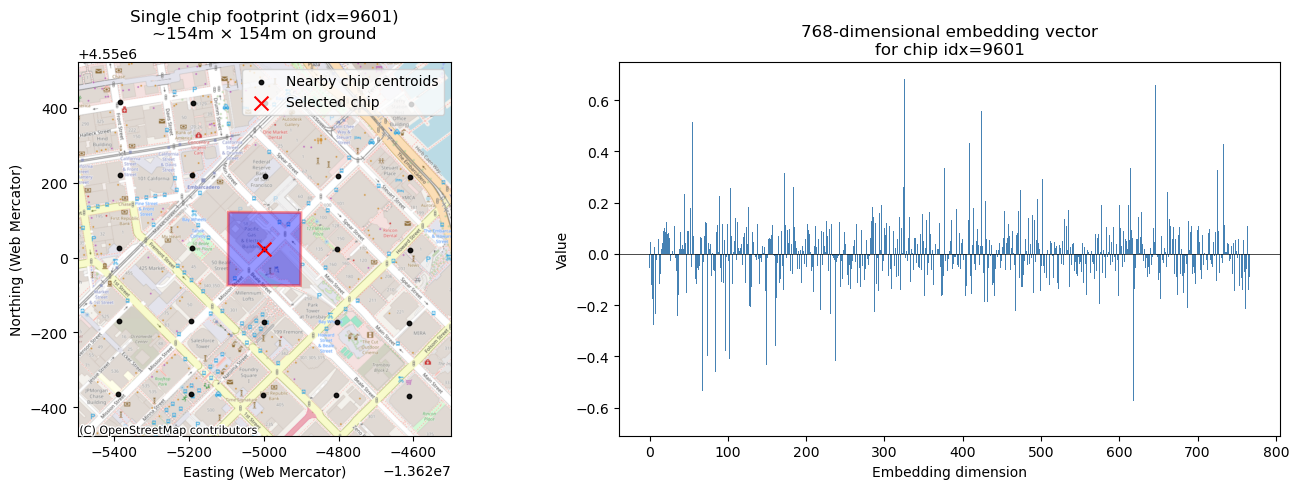

Chip 9601:
  Location: -122.3954°, 37.7916°
  Approx size: 154m × 154m
  Embedding: 768 dimensions, range [-0.64, 0.68]


In [7]:
# Visualize a single chip's footprint and its embedding
from matplotlib.patches import Polygon as MplPolygon

# Helper to convert geometry to shapely polygon
def to_polygon(g):
    if isinstance(g, (bytes, bytearray, memoryview)):
        return from_wkb(bytes(g))
    try:
        return shape(g)
    except:
        return g

# Helper to extract centroid from geometry
def get_centroid(g):
    if isinstance(g, (bytes, bytearray, memoryview)):
        poly = from_wkb(bytes(g))
    else:
        try:
            poly = shape(g)
        except:
            poly = g
    c = poly.centroid
    return c.x, c.y

if SHAPELY_OK:

    # Get centroids of all chips
    centroids = [get_centroid(g) for g in emb_df["geometry"].values]
    xs, ys = zip(*centroids)

    # Convert to Web Mercator for basemap
    xs_merc, ys_merc = lonlat_to_webmerc(xs, ys)

    # Pick a chip near the center of the dataset
    chip_idx = len(emb_df) // 3
    chip_row = emb_df.iloc[chip_idx]
    chip_geom = to_polygon(chip_row["geometry"])
    chip_emb = chip_row["embeddings"]
    
    # Get polygon coordinates and convert to Web Mercator
    poly_coords = list(chip_geom.exterior.coords)
    poly_lons, poly_lats = zip(*poly_coords)
    poly_xs, poly_ys = lonlat_to_webmerc(poly_lons, poly_lats)
    
    # Calculate chip size
    chip_width_m = chip_geom.bounds[2] - chip_geom.bounds[0]  # in degrees
    chip_width_m_approx = chip_width_m * 111000 * np.cos(np.radians(np.mean(poly_lats)))  # rough meters
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Chip footprint on map with surrounding chips
    ax = axes[0]
    
    # Show nearby chips as context (within ~500m)
    cx_chip, cy_chip = chip_geom.centroid.x, chip_geom.centroid.y
    nearby_mask = [(abs(xs[i] - cx_chip) < 0.01) and (abs(ys[i] - cy_chip) < 0.01) 
                   for i in range(len(xs))]
    nearby_xs = [xs_merc[i] for i, m in enumerate(nearby_mask) if m]
    nearby_ys = [ys_merc[i] for i, m in enumerate(nearby_mask) if m]
    ax.scatter(nearby_xs, nearby_ys, s=10, alpha=0.9, c='black', label='Nearby chip centroids')
    
    # Draw the selected chip polygon
    poly_verts = list(zip(poly_xs, poly_ys))
    patch = MplPolygon(poly_verts, fill=True, facecolor='blue', edgecolor='red', 
                       alpha=0.4, linewidth=2, zorder=5)
    ax.add_patch(patch)
    
    # Mark centroid
    cx_merc, cy_merc = lonlat_to_webmerc([cx_chip], [cy_chip])
    ax.scatter(cx_merc, cy_merc, s=100, c='red', marker='x', zorder=10, label='Selected chip')
    
    ax.set_xlabel("Easting (Web Mercator)")
    ax.set_ylabel("Northing (Web Mercator)")
    ax.set_title(f"Single chip footprint (idx={chip_idx})\n~{chip_width_m_approx:.0f}m × {chip_width_m_approx:.0f}m on ground")
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    
    # Zoom to chip area
    pad = 500  # meters padding
    ax.set_xlim(cx_merc[0] - pad, cx_merc[0] + pad)
    ax.set_ylim(cy_merc[0] - pad, cy_merc[0] + pad)
    
    if CONTEXTILY_OK:
        cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.OpenStreetMap.Mapnik, alpha=0.8)
    
    # Right: The embedding vector itself
    ax2 = axes[1]
    ax2.bar(range(len(chip_emb)), chip_emb, width=1.0, color='steelblue', edgecolor='none')
    ax2.set_xlabel("Embedding dimension")
    ax2.set_ylabel("Value")
    ax2.set_title(f"{len(chip_emb)}-dimensional embedding vector\nfor chip idx={chip_idx}")
    ax2.axhline(0, color='black', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Chip {chip_idx}:")
    print(f"  Location: {cx_chip:.4f}°, {cy_chip:.4f}°")
    print(f"  Approx size: {chip_width_m_approx:.0f}m × {chip_width_m_approx:.0f}m")
    print(f"  Embedding: {len(chip_emb)} dimensions, range [{min(chip_emb):.2f}, {max(chip_emb):.2f}]")
else:
    print("Shapely required for this visualization")

### Visualizing the distribution and spatial coverage

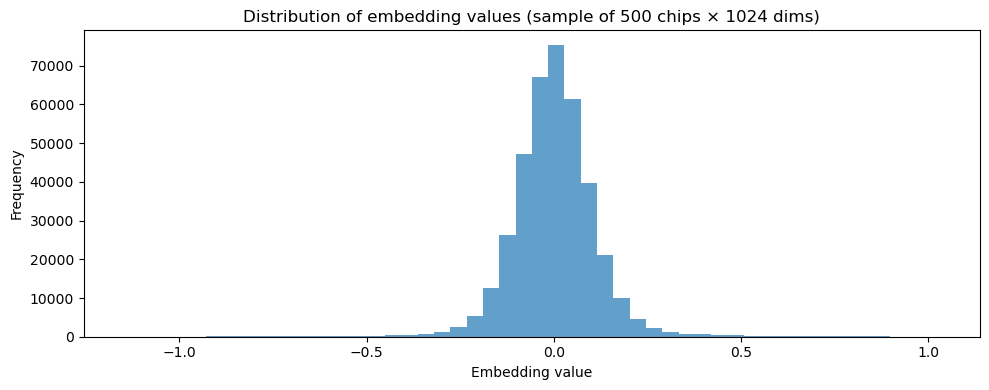

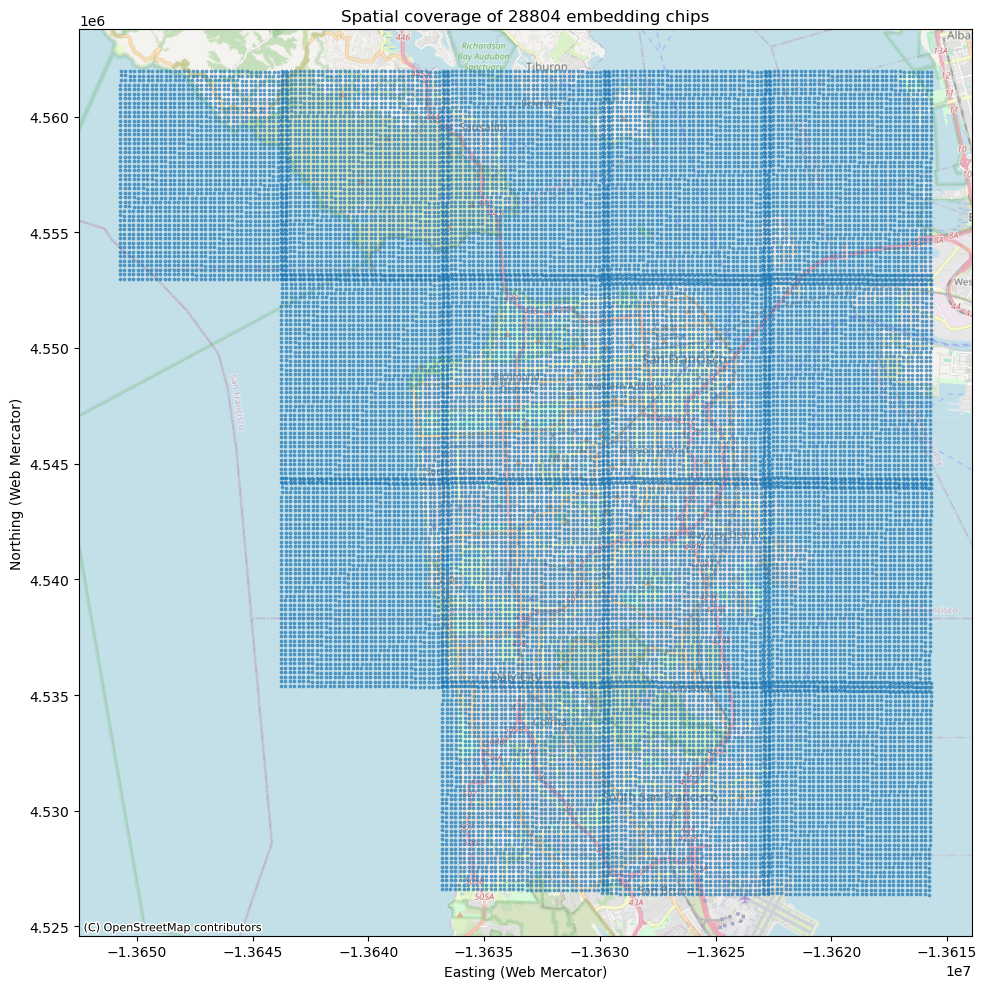

In [8]:
# Visualize embeddings: distribution and spatial coverage

# Plot 1: Embedding value distribution
fig, ax = plt.subplots(figsize=(10, 4))
sample_embs = np.vstack(emb_df["embeddings"].head(500).values)
ax.hist(sample_embs.flatten(), bins=50, edgecolor='none', alpha=0.7)
ax.set_xlabel("Embedding value")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of embedding values (sample of 500 chips × 1024 dims)")
plt.tight_layout()
plt.show()

# Plot 2: Spatial coverage of chips with basemap
if SHAPELY_OK:
    
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.scatter(xs_merc, ys_merc, s=3, alpha=0.6, zorder=2)
    ax.set_xlabel("Easting (Web Mercator)")
    ax.set_ylabel("Northing (Web Mercator)")
    ax.set_title(f"Spatial coverage of {len(emb_df)} embedding chips")
    
    # Add basemap if available
    if CONTEXTILY_OK:
        cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.OpenStreetMap.Mapnik, alpha=0.7)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()
else:
    print("Shapely required for spatial plot")

## 6. Load training points (GeoJSON)

The dataset includes two small hand-labelled sets of points:
- `marinas.geojson`
- `baseball.geojson`

Each feature is expected to include a `class` property:
- `1` = positive example (marina or baseball field)
- `0` = negative example (other land cover)

We will use these to label the embedding chips by spatial containment.

In [9]:
def load_geojson_points(path: Path):
    with open(path, "r") as f:
        gj = json.load(f)
    feats = gj["features"]
    records = []
    for feat in feats:
        geom = feat["geometry"]
        props = feat.get("properties", {})
        records.append({
            "geometry": geom,
            "class": props.get("class", None),
            "properties": props
        })
    df = pd.DataFrame(records)
    return df

points_path = DATA_DIR / (f"{TASK}.geojson")
pts_df = load_geojson_points(points_path)
print("Points:", pts_df.shape)
print("Class counts:\n", pts_df["class"].value_counts(dropna=False))

if not SHAPELY_OK:
    print("WARNING: Shapely not available, cannot perform spatial join.")

Points: (170, 3)
Class counts:
 class
0    145
1     25
Name: count, dtype: int64


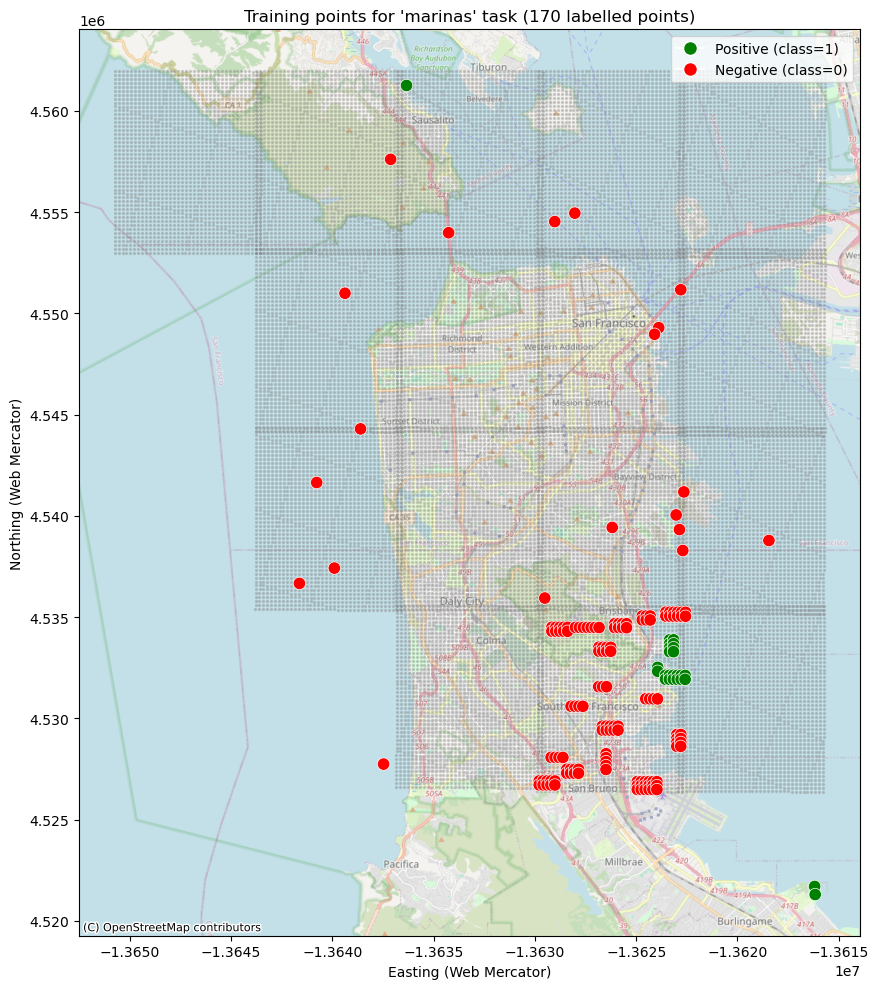

In [10]:
# Visualize training points on top of chip coverage with basemap
if SHAPELY_OK:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Background: all chip centroids (light gray) in Web Mercator
    ax.scatter(xs_merc, ys_merc, s=2, alpha=0.3, c='gray', label='Chips', zorder=2)
    
    # Training points colored by class
    pt_coords = []
    pt_classes = []
    for _, r in pts_df.iterrows():
        pt = shape(r["geometry"])
        if pt.geom_type == "Point":
            pt_coords.append((pt.x, pt.y))
            pt_classes.append(r["class"])
    
    if pt_coords:
        pt_xs, pt_ys = zip(*pt_coords)
        pt_xs_merc, pt_ys_merc = lonlat_to_webmerc(pt_xs, pt_ys)
        colors = ['red' if c == 0 else 'green' for c in pt_classes]
        ax.scatter(pt_xs_merc, pt_ys_merc, s=80, c=colors, edgecolor='white', linewidth=0.5, zorder=5)
        
        # Legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Positive (class=1)'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Negative (class=0)'),
        ]
        ax.legend(handles=legend_elements, loc='upper right')
    
    ax.set_xlabel("Easting (Web Mercator)")
    ax.set_ylabel("Northing (Web Mercator)")
    ax.set_title(f"Training points for '{TASK}' task ({len(pt_coords)} labelled points)")
    
    # Add basemap if available
    if CONTEXTILY_OK:
        cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.OpenStreetMap.Mapnik, alpha=0.7)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
else:
    print("Shapely required for spatial visualization")

## 7. Spatial join: assign point labels to embedding chips

We label each embedding chip by checking which training points fall within its geographic footprint (point-in-polygon test).

This creates a training table of `(embedding_vector, class_label)`.

This is intentionally implemented **without GeoPandas** to reduce heavy dependencies.

If this is slow, reduce `MAX_FILES`, or sample fewer points.

In [11]:
# Convert embedding geometries (stored as WKB) to shapely polygons (shapely>=2)
# Many parquet writers store geometry as bytes (WKB). If yours stores as WKT/GeoJSON, adapt below.
def to_polygon(g):
    if isinstance(g, (bytes, bytearray, memoryview)):
        return from_wkb(bytes(g))
    # sometimes already shapely geometry or dict
    try:
        return shape(g)
    except Exception:
        return g  # fallback

# Convert points to shapely Points
def to_point(geom_dict):
    shp = shape(geom_dict)
    if shp.geom_type == "Point":
        return shp
    # If it's something else, take centroid
    return shp.centroid

# Precompute polygons + bounds for speed
polys = [to_polygon(g) for g in emb_df["geometry"].values]
bounds = np.array([p.bounds for p in polys])  # (minx, miny, maxx, maxy)
print("Prepared", len(polys), "polygons")

# For each point, find candidate polygons by bbox test then exact contains()
train_rows = []
for i, r in pts_df.iterrows():
    cls = r["class"]
    if cls is None:
        continue
    pt = to_point(r["geometry"])
    x, y = pt.x, pt.y

    # bbox filter
    cand = np.where((bounds[:,0] <= x) & (bounds[:,2] >= x) & (bounds[:,1] <= y) & (bounds[:,3] >= y))[0]
    found = None
    for j in cand:
        if polys[j].contains(pt):
            found = j
            break
    if found is not None:
        train_rows.append({"emb_idx": int(found), "class": int(cls)})

train_df = pd.DataFrame(train_rows).drop_duplicates("emb_idx")
print("Training rows found:", len(train_df))
print(train_df["class"].value_counts())

# Merge labels onto embeddings (only for training rows)
train_merged = emb_df.iloc[train_df["emb_idx"].values].copy()
train_merged["class"] = train_df["class"].values

X = np.vstack(train_merged["embeddings"].values)
y = train_merged["class"].values

print("X:", X.shape, "y:", y.shape, "pos rate:", y.mean() if len(y) else None)


Prepared 28804 polygons
Training rows found: 167
class
0    144
1     23
Name: count, dtype: int64
X: (167, 768) y: (167,) pos rate: 0.1377245508982036


## 8. Train a classifier on embeddings

We'll try:
- **Random Forest**: robust, non-linear, strong baseline
- **Logistic Regression**: fast linear probe baseline

The goal is to show how far you can get **without fine-tuning the foundation model** — just training a small classifier on frozen embeddings.

In [12]:
if len(np.unique(y)) < 2:
    raise RuntimeError("Need at least two classes in training data. Try switching TASK or increasing MAX_FILES.")

# Check if we have enough samples for stratified splitting
min_class_count = min(np.bincount(y))
use_stratify = min_class_count >= 2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED, 
    stratify=y if use_stratify else None
)

if not use_stratify:
    print("Note: Using non-stratified split due to small sample size. Increase MAX_FILES for better results.")

# Show class balance
print("Training set class distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Test set class distribution:", dict(zip(*np.unique(y_test, return_counts=True))))

# Baseline: logistic regression (linear probe) with balanced class weights
lin = LogisticRegression(max_iter=2000, class_weight='balanced')
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)

print("\n=== Logistic Regression (linear probe, balanced weights) ===")
print("Accuracy:", accuracy_score(y_test, pred_lin))
print("Precision:", precision_score(y_test, pred_lin, zero_division=0))
print("Recall:", recall_score(y_test, pred_lin, zero_division=0))
print(classification_report(y_test, pred_lin, zero_division=0))

# Strong baseline: Random Forest with balanced class weights
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=RANDOM_SEED)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("\n=== Random Forest (balanced weights) ===")
print("Accuracy:", accuracy_score(y_test, pred_rf))
print("Precision:", precision_score(y_test, pred_rf, zero_division=0))
print("Recall:", recall_score(y_test, pred_rf, zero_division=0))
print(classification_report(y_test, pred_rf, zero_division=0))

Training set class distribution: {np.int64(0): np.int64(100), np.int64(1): np.int64(16)}
Test set class distribution: {np.int64(0): np.int64(44), np.int64(1): np.int64(7)}

=== Logistic Regression (linear probe, balanced weights) ===
Accuracy: 0.9411764705882353
Precision: 0.75
Recall: 0.8571428571428571
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.75      0.86      0.80         7

    accuracy                           0.94        51
   macro avg       0.86      0.91      0.88        51
weighted avg       0.95      0.94      0.94        51


=== Random Forest (balanced weights) ===
Accuracy: 0.9411764705882353
Precision: 1.0
Recall: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        44
           1       1.00      0.57      0.73         7

    accuracy                           0.94        51
   macro avg       0.97      0.79   

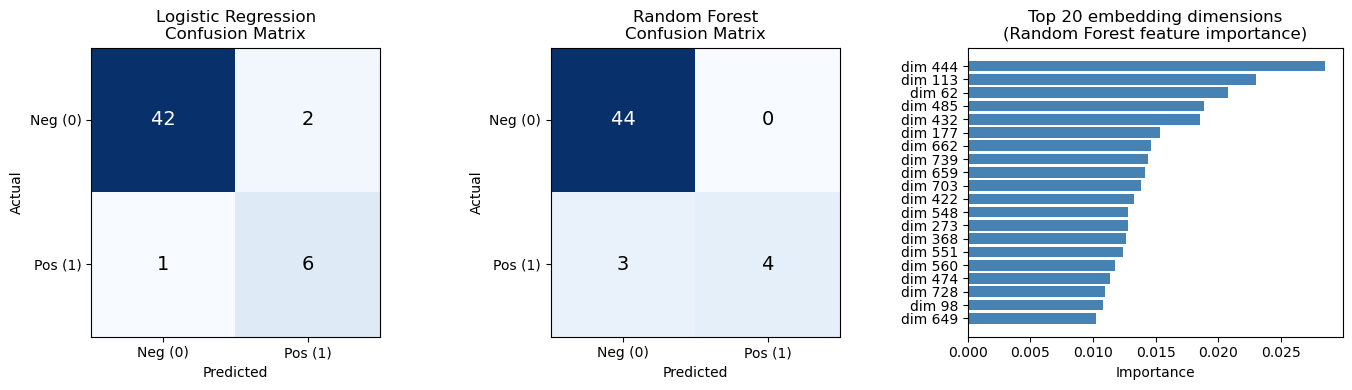

In [13]:
# Visualize classifier performance

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Confusion matrices (force 2x2 by specifying labels)
for ax, preds, name in [(axes[0], pred_lin, "Logistic Regression"), (axes[1], pred_rf, "Random Forest")]:
    cm = confusion_matrix(y_test, preds, labels=[0, 1])  # force 2x2
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Neg (0)', 'Pos (1)'])
    ax.set_yticklabels(['Neg (0)', 'Pos (1)'])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"{name}\nConfusion Matrix")
    # Annotate cells
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', 
                   color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=14)

# Feature importance (Random Forest)
importances = rf.feature_importances_
top_k = 20
top_idx = np.argsort(importances)[-top_k:]
axes[2].barh(range(top_k), importances[top_idx], color='steelblue')
axes[2].set_yticks(range(top_k))
axes[2].set_yticklabels([f"dim {i}" for i in top_idx])
axes[2].set_xlabel("Importance")
axes[2].set_title(f"Top {top_k} embedding dimensions\n(Random Forest feature importance)")

plt.tight_layout()
plt.show()

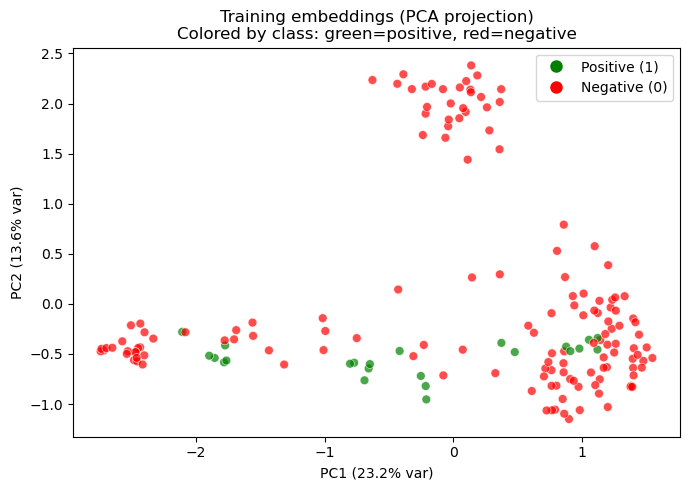

PCA explained variance: 36.8% in 2 components


In [14]:
# PCA visualization of training embeddings colored by class
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(7, 5))
colors = ['red' if c == 0 else 'green' for c in y]
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=40, alpha=0.7, edgecolor='white', linewidth=0.5)

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
ax.set_title("Training embeddings (PCA projection)\nColored by class: green=positive, red=negative")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Positive (1)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Negative (0)'),
]
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum()*100:.1f}% in 2 components")

## 9. Inference over the entire embedding table

Now we apply the trained classifier over **all** embeddings (not just labelled ones) to "discover" likely target locations across the AOI.

In [15]:
# Choose which classifier to use for inference
model = rf  # or lin

X_all = np.vstack(emb_df["embeddings"].values)
pred_all = model.predict(X_all)
print("Predicted positives:", int(pred_all.sum()), "out of", len(pred_all))

# Keep top candidates (if model supports predict_proba)
if hasattr(model, "predict_proba"):
    proba = model.predict_proba(X_all)[:, 1]
    topk = np.argsort(-proba)[:20]
    print("\nTop-20 candidates by probability:")
    for rank, idx in enumerate(topk, 1):
        print(rank, "idx", int(idx), "p", float(proba[idx]))
else:
    topk = np.where(pred_all == 1)[0][:20]
    print("\nTop candidates (no probabilities):", topk[:10])


Predicted positives: 39 out of 28804

Top-20 candidates by probability:
1 idx 23822 p 0.86
2 idx 24052 p 0.86
3 idx 23747 p 0.8466666666666667
4 idx 23746 p 0.8433333333333334
5 idx 24091 p 0.8366666666666667
6 idx 23708 p 0.8333333333333334
7 idx 24049 p 0.82
8 idx 23785 p 0.81
9 idx 23709 p 0.79
10 idx 24090 p 0.7866666666666666
11 idx 25842 p 0.77
12 idx 24089 p 0.77
13 idx 24087 p 0.77
14 idx 24050 p 0.7566666666666667
15 idx 23784 p 0.72
16 idx 23971 p 0.72
17 idx 24009 p 0.72
18 idx 24053 p 0.7166666666666667
19 idx 23970 p 0.71
20 idx 25841 p 0.71


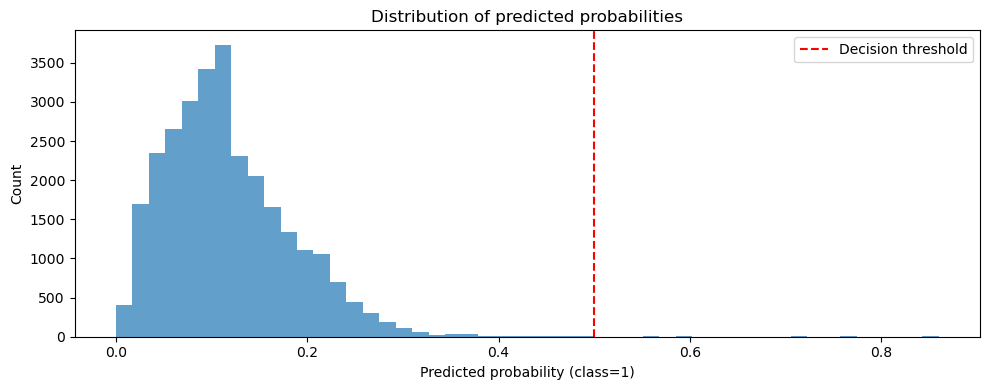

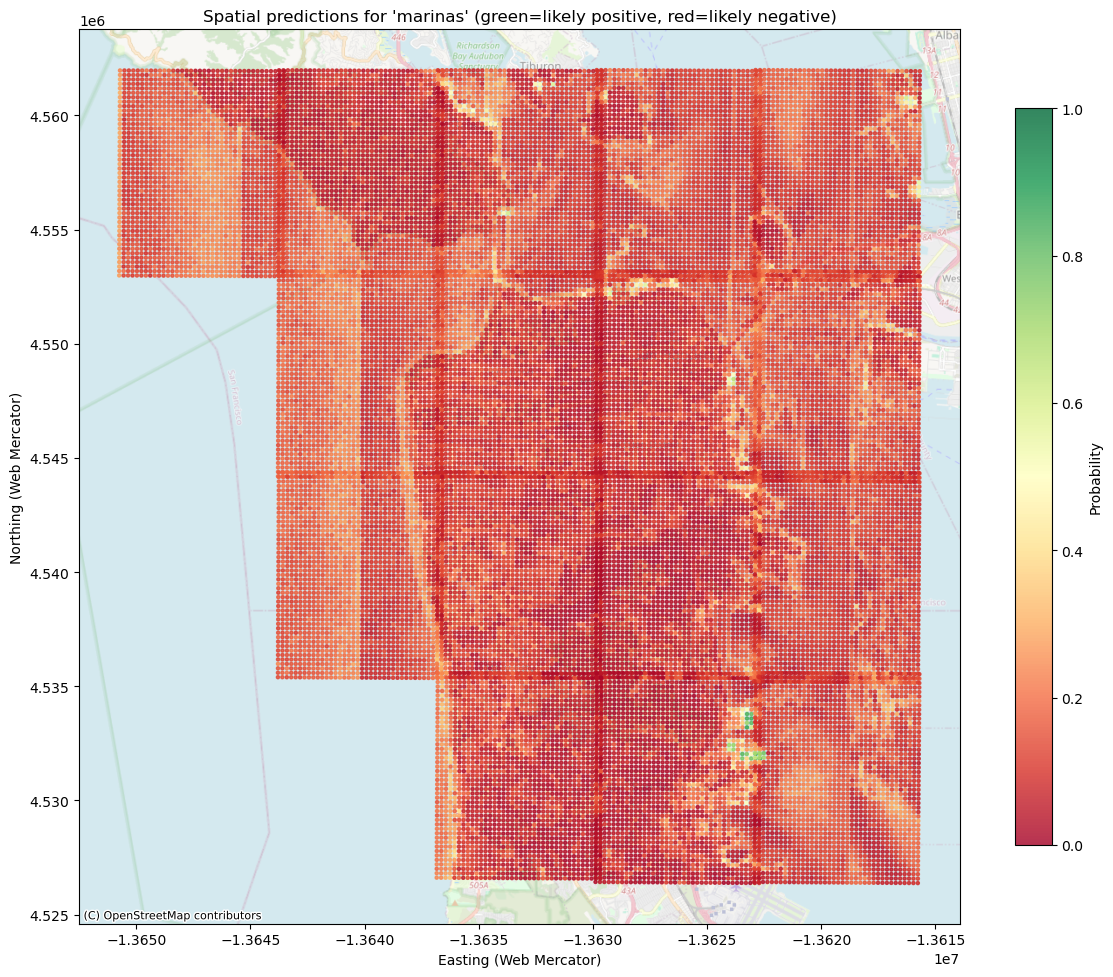

In [16]:
# Visualize inference results

# Plot 1: Probability distribution
fig, ax = plt.subplots(figsize=(10, 4))
if hasattr(model, "predict_proba"):
    ax.hist(proba, bins=50, edgecolor='none', alpha=0.7)
    ax.axvline(0.5, color='red', linestyle='--', label='Decision threshold')
    ax.set_xlabel("Predicted probability (class=1)")
    ax.set_ylabel("Count")
    ax.set_title("Distribution of predicted probabilities")
    ax.legend()
else:
    ax.hist(pred_all, bins=3, edgecolor='white')
    ax.set_title("Prediction distribution (no probabilities)")
plt.tight_layout()
plt.show()

# Plot 2: Spatial prediction map with basemap
if SHAPELY_OK:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Color by probability (or prediction if no proba)
    if hasattr(model, "predict_proba"):
        colors = proba
        label = 'Probability'
    else:
        colors = pred_all
        label = 'Prediction'
    
    sc = ax.scatter(xs_merc, ys_merc, c=colors, cmap='RdYlGn', s=5, alpha=0.8, 
                    vmin=0, vmax=1, zorder=2)
    plt.colorbar(sc, ax=ax, label=label, shrink=0.8)
    ax.set_xlabel("Easting (Web Mercator)")
    ax.set_ylabel("Northing (Web Mercator)")
    ax.set_title(f"Spatial predictions for '{TASK}' (green=likely positive, red=likely negative)")
    
    # Add basemap if available
    if CONTEXTILY_OK:
        cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.OpenStreetMap.Mapnik, alpha=0.5)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()
else:
    print("Shapely required for spatial visualization")

## 9. Spatial generalization test (held-out coastal area)

A critical test for geospatial models is whether they **generalize spatially** — can a model trained on one area detect targets in a nearby but unseen region?

We held out the southern Bay Area tiles (3712228, 3712229, 3712230) during training. Now we evaluate predictions on this unseen coastline.

In [17]:
# Load spatial test embeddings (held-out southern tiles)
spatial_test_df = load_embeddings([DATA_DIR / f for f in SPATIAL_TEST_FILES])
print(f"Spatial test set: {len(spatial_test_df)} chips from {len(SPATIAL_TEST_FILES)} tiles")

# Extract embeddings and predict
X_spatial = np.vstack(spatial_test_df["embeddings"].values)
pred_spatial = model.predict(X_spatial)
print(f"Predicted positives in spatial test area: {pred_spatial.sum()} / {len(pred_spatial)}")

# Get probabilities if available
if hasattr(model, "predict_proba"):
    proba_spatial = model.predict_proba(X_spatial)[:, 1]
    print(f"Probability range: {proba_spatial.min():.3f} - {proba_spatial.max():.3f}")
    print(f"Mean probability: {proba_spatial.mean():.3f}")

# Get centroids for spatial test chips
if SHAPELY_OK:
    spatial_centroids = [get_centroid(g) for g in spatial_test_df["geometry"].values]
    xs_spatial, ys_spatial = zip(*spatial_centroids)
    xs_spatial_merc, ys_spatial_merc = lonlat_to_webmerc(xs_spatial, ys_spatial)

Spatial test set: 7220 chips from 4 tiles
Predicted positives in spatial test area: 3 / 7220
Probability range: 0.000 - 0.607
Mean probability: 0.091


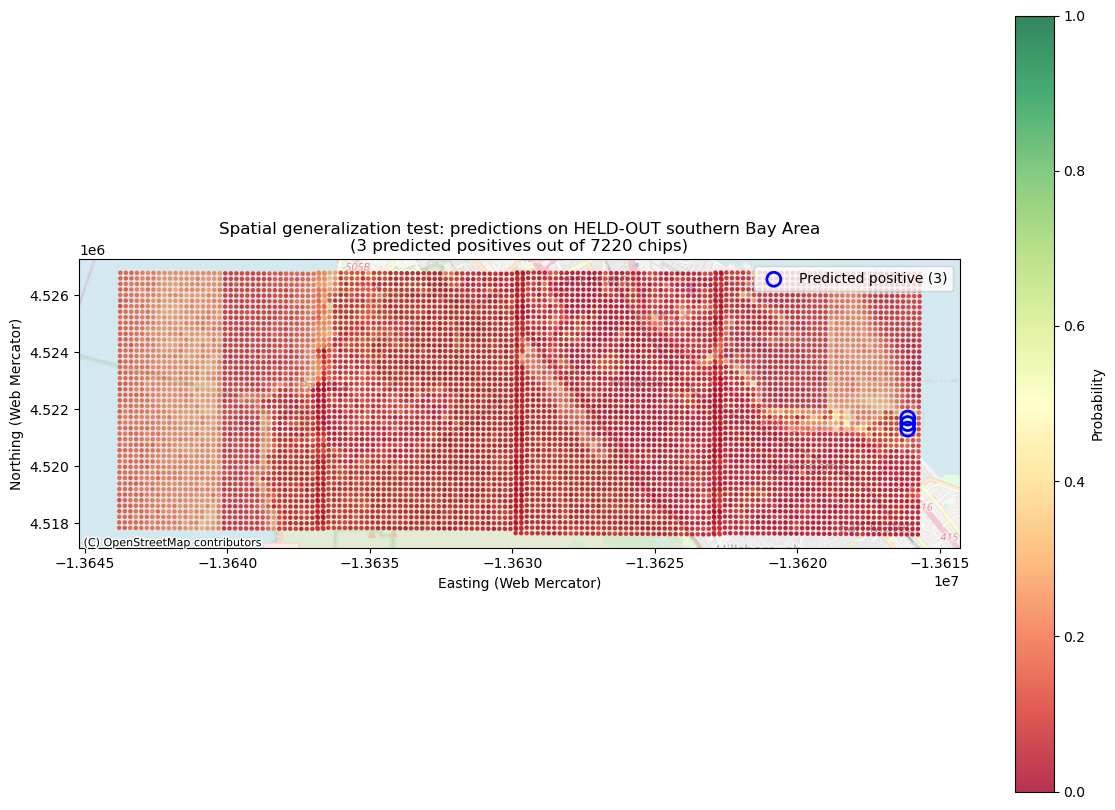

In [18]:
# Visualize spatial test predictions
if SHAPELY_OK:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Color by probability
    if hasattr(model, "predict_proba"):
        colors = proba_spatial
        label = 'Probability'
    else:
        colors = pred_spatial
        label = 'Prediction'
    
    sc = ax.scatter(xs_spatial_merc, ys_spatial_merc, c=colors, cmap='RdYlGn', 
                    s=5, alpha=0.8, vmin=0, vmax=1, zorder=2)
    plt.colorbar(sc, ax=ax, label=label, shrink=0.8)
    
    # Highlight predicted positives
    pos_mask = pred_spatial == 1
    if pos_mask.sum() > 0:
        ax.scatter(np.array(xs_spatial_merc)[pos_mask], np.array(ys_spatial_merc)[pos_mask],
                   s=100, facecolors='none', edgecolors='blue', linewidth=2, 
                   zorder=5, label=f'Predicted positive ({pos_mask.sum()})')
        ax.legend(loc='upper right')
    
    ax.set_xlabel("Easting (Web Mercator)")
    ax.set_ylabel("Northing (Web Mercator)")
    ax.set_title(f"Spatial generalization test: predictions on HELD-OUT southern Bay Area\n"
                 f"({pred_spatial.sum()} predicted positives out of {len(pred_spatial)} chips)")
    
    if CONTEXTILY_OK:
        cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.OpenStreetMap.Mapnik, alpha=0.5)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()
else:
    print("Shapely required for visualization")

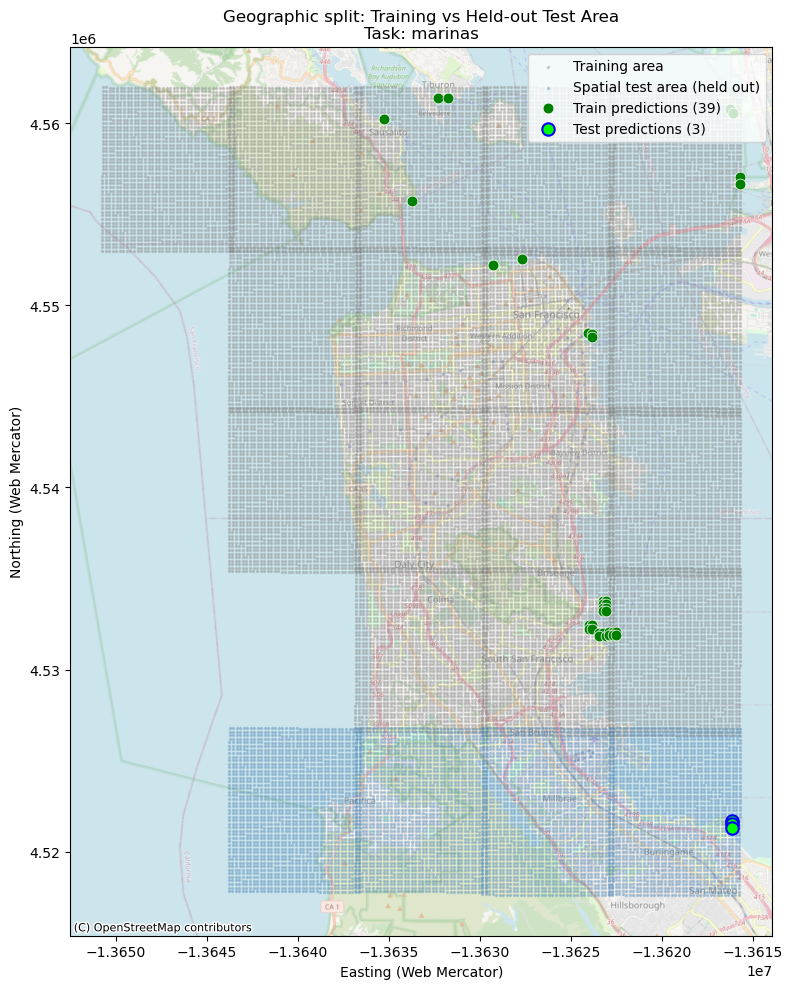


Summary:
  Training area: 28804 chips, 39 predicted positives
  Test area:     7220 chips, 3 predicted positives


In [19]:
# Combined view: training area vs spatial test area
if SHAPELY_OK:
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Training area (gray)
    ax.scatter(xs_merc, ys_merc, s=2, alpha=0.3, c='gray', label='Training area', zorder=1)
    
    # Spatial test area (blue outline)
    ax.scatter(xs_spatial_merc, ys_spatial_merc, s=2, alpha=0.3, c='steelblue', 
               label='Spatial test area (held out)', zorder=1)
    
    # Predicted positives in training area
    train_pos = pred_all == 1
    if train_pos.sum() > 0:
        ax.scatter(np.array(xs_merc)[train_pos], np.array(ys_merc)[train_pos],
                   s=60, c='green', edgecolor='white', linewidth=0.5,
                   zorder=5, label=f'Train predictions ({train_pos.sum()})')
    
    # Predicted positives in test area
    test_pos = pred_spatial == 1
    if test_pos.sum() > 0:
        ax.scatter(np.array(xs_spatial_merc)[test_pos], np.array(ys_spatial_merc)[test_pos],
                   s=80, c='lime', edgecolor='blue', linewidth=1.5,
                   zorder=6, label=f'Test predictions ({test_pos.sum()})')
    
    ax.set_xlabel("Easting (Web Mercator)")
    ax.set_ylabel("Northing (Web Mercator)")
    ax.set_title(f"Geographic split: Training vs Held-out Test Area\n"
                 f"Task: {TASK}")
    ax.legend(loc='upper right')
    
    if CONTEXTILY_OK:
        cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.OpenStreetMap.Mapnik, alpha=0.6)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()
    
    print(f"\nSummary:")
    print(f"  Training area: {len(emb_df)} chips, {train_pos.sum()} predicted positives")
    print(f"  Test area:     {len(spatial_test_df)} chips, {test_pos.sum()} predicted positives")
else:
    print("Shapely required for visualization")

## 10. Similarity search on embeddings (retrieval)

Because embeddings capture semantic content, we can find **similar chips** using vector distance. Two common uses:

1. **QA / debugging**: "show me chips similar to this false positive"
2. **Weak supervision / curation**: "find more examples like my few positives"

We build a cosine-distance nearest-neighbour index and query from one positive example.

In [20]:
# Build a cosine nearest-neighbour index (sklearn; CPU-friendly)
X_norm = X_all / (np.linalg.norm(X_all, axis=1, keepdims=True) + 1e-12)

nn = NearestNeighbors(n_neighbors=10, metric="cosine")
nn.fit(X_norm)

# Pick a query embedding: a known positive from training set if possible
pos_indices = train_merged.index[train_merged["class"] == 1].tolist()
if len(pos_indices) == 0:
    query_idx = int(topk[0])
else:
    query_idx = int(pos_indices[0])

dist, ind = nn.kneighbors(X_norm[query_idx:query_idx+1], n_neighbors=10, return_distance=True)
print("Query idx:", query_idx)
print("Nearest neighbours (cosine distance):")
for d, i in zip(dist[0], ind[0]):
    print(f"  idx={int(i):5d}  dist={float(d):.4f}  pred={int(pred_all[i])}")


Query idx: 23971
Nearest neighbours (cosine distance):
  idx=23971  dist=0.0000  pred=1
  idx=23742  dist=0.1371  pred=0
  idx=23972  dist=0.1423  pred=0
  idx=24312  dist=0.1509  pred=0
  idx=23855  dist=0.1530  pred=0
  idx=24413  dist=0.1543  pred=0
  idx=18463  dist=0.1579  pred=0
  idx=18625  dist=0.1589  pred=0
  idx=23933  dist=0.1611  pred=0
  idx=24515  dist=0.1623  pred=0


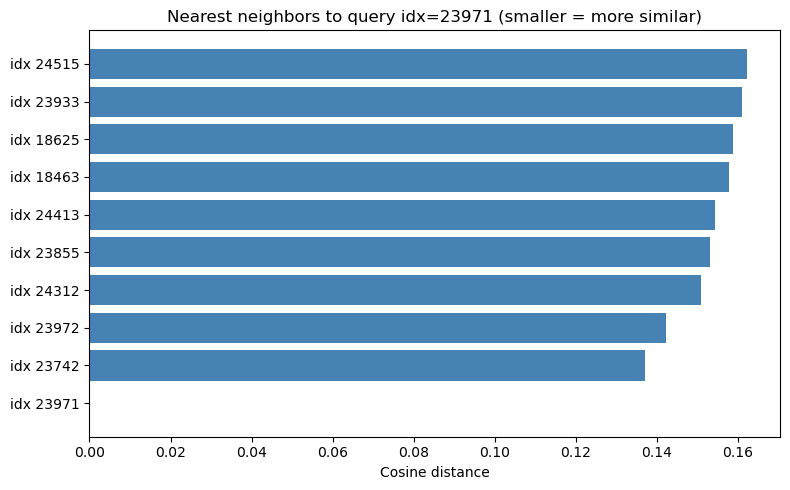

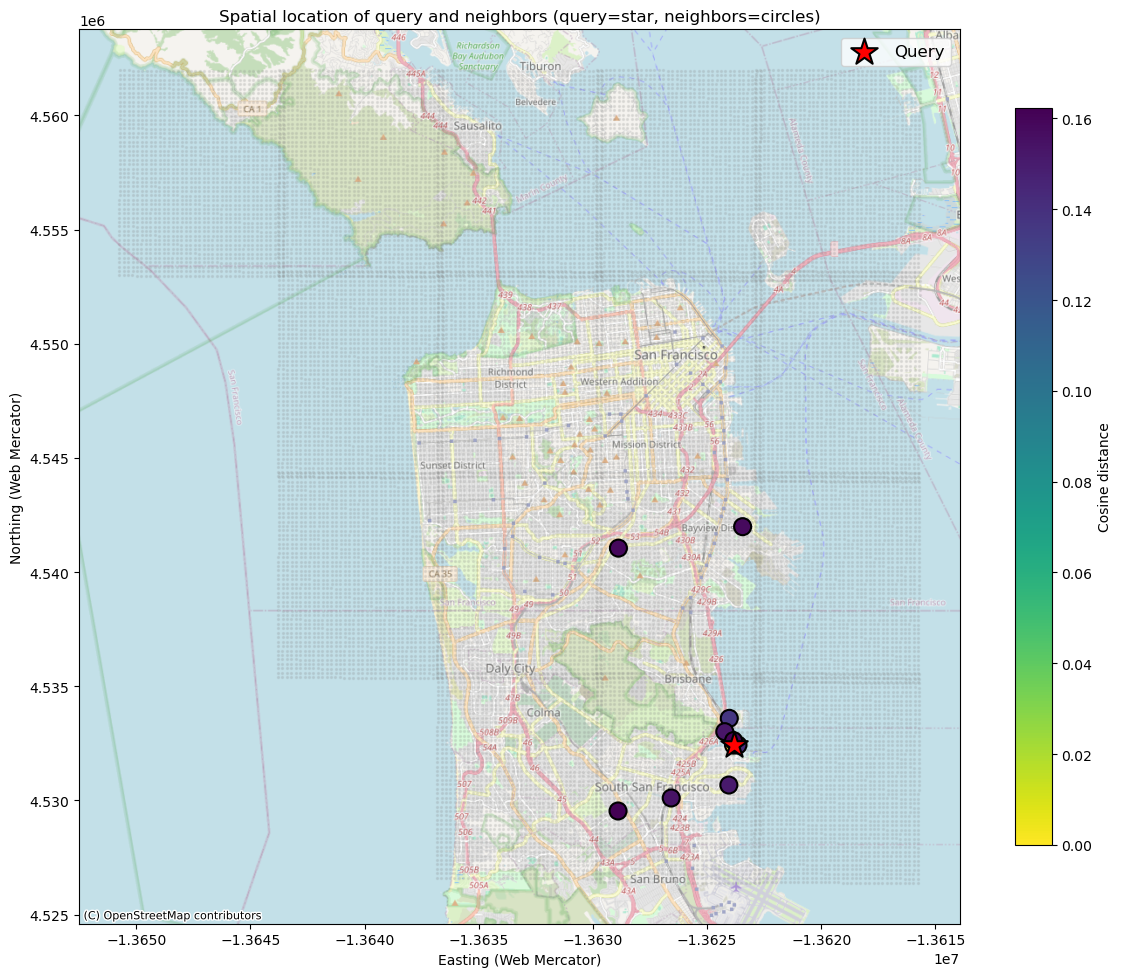

In [21]:
# Visualize retrieval results

# Plot 1: Bar chart of distances to nearest neighbors
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(range(len(ind[0])), dist[0][::-1], color='steelblue')
ax.set_yticks(range(len(ind[0])))
ax.set_yticklabels([f"idx {i}" for i in ind[0][::-1]])
ax.set_xlabel("Cosine distance")
ax.set_title(f"Nearest neighbors to query idx={query_idx} (smaller = more similar)")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Plot 2: Spatial view - highlight query and neighbors with basemap
if SHAPELY_OK:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Background chips
    ax.scatter(xs_merc, ys_merc, s=2, alpha=0.15, c='gray', zorder=1)
    
    # Highlight neighbors
    neighbor_xs_merc = [xs_merc[i] for i in ind[0]]
    neighbor_ys_merc = [ys_merc[i] for i in ind[0]]
    neighbor_colors = dist[0]  # color by distance
    sc = ax.scatter(neighbor_xs_merc, neighbor_ys_merc, c=neighbor_colors, cmap='viridis_r', 
                    s=150, edgecolor='black', linewidth=1.5, zorder=5)
    plt.colorbar(sc, ax=ax, label='Cosine distance', shrink=0.8)
    
    # Mark query with star
    ax.scatter([xs_merc[query_idx]], [ys_merc[query_idx]], marker='*', s=400, c='red', 
               edgecolor='black', linewidth=1.5, zorder=10, label='Query')
    
    ax.set_xlabel("Easting (Web Mercator)")
    ax.set_ylabel("Northing (Web Mercator)")
    ax.legend(loc='upper right', fontsize=12)
    ax.set_title("Spatial location of query and neighbors (query=star, neighbors=circles)")
    
    # Add basemap if available
    if CONTEXTILY_OK:
        cx.add_basemap(ax, crs="EPSG:3857", source=cx.providers.OpenStreetMap.Mapnik, alpha=0.7)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()
else:
    print("Shapely required for spatial visualization")

## Where this goes next (bridge to Practical 3 and beyond)

This practical demonstrated the **embeddings-first** workflow:
- Freeze a foundation model encoder
- Train lightweight classifiers on embeddings
- Use vector similarity for retrieval

**Next steps:**
- **Fine-tuning / LoRA:** instead of freezing the embedding model, update a small subset of parameters (Practical 3)
- **Operationalising:** chip creation (STAC), batching, vector stores, and monitoring

**Extensions for this notebook:**
1. Replace precomputed embeddings with **fresh embeddings** generated by Clay for a new AOI/time window
2. Swap the classifier for a small MLP head (PyTorch) and compare
3. Build a proper vector index (FAISS/HNSW) and add metadata filtering (time/location/sensor)

## Exercise: Apply to MiraBest Radio Galaxies

Apply the embeddings-first workflow to radio astronomy data!

### About MiraBest

**MiraBest** contains labelled Fanaroff-Riley radio galaxies:
- **FRI** (class 0): edge-darkened morphology
- **FRII** (class 1): edge-brightened morphology
- ~800 images (150×150 grayscale) in CIFAR-style pickle format
- Zenodo: https://doi.org/10.5281/zenodo.4288837

### Setup

Use your autoencoder from Session 1A (or train a new one) to generate embeddings for MiraBest images. Alternatively, use PCA on flattened pixels as a baseline.

### Tasks

1. **Load MiraBest** — Download `batches.tar.gz` and load pickle batches (same code as Session 1A)

2. **Generate embeddings** — Two options:
   - Use your trained encoder from Session 1A
   - PCA on flattened pixels (simpler baseline)

3. **Train classifiers** — Random Forest and Logistic Regression on embeddings

4. **Evaluate** — Create confusion matrices for FRI vs FRII classification
   - Random baseline is 50% (binary classification)

5. **Similarity search** — Find similar galaxies using embedding distance

### Questions to explore

- How does autoencoder embedding accuracy compare to raw-pixel PCA?
- Which FR class is harder to classify?
- Do similar embeddings correspond to similar morphologies?

### Solution

See **Session2A_Extension_MiraBest.ipynb** for a complete worked solution.